<div style="color:#d3d3d3;text-align:right;">For a better experience open in Jupyterlab.</div>

# Quantum Algorithm for Hamiltonian Simulation of Coupled Classical Oscillators

The dynamics of a classical system of coupled oscillators with $s$ degrees of freedom could accurately be described by a superposition of _normal modes_. Our objective here is to deploy a quantum algorithm that would meaningfully deliver the dynamics of a 1-dimensional system of $N$ coupled classical oscillators through a Hamiltonian simulation over time.

## Introduction

A 1-dimensional system of coupled oscillators is composed of $N$ masses interacting with each other according to Hook's law and each mass could also be imagined to be connected to a hard wall with a spring. The set of equations of motion for such a system could be easily obtained using the principle of least action and Lagrangian mechanics in terms of small displacements $x_j = q_j - q_{j0}$ ( $q_j$'s are the generalized coordinates and $q_{j0}$'s are the equilibrium coordinates of the masses).
$$
\begin{aligned}
U (x_1, \ldots, x_N) &= \frac{1}{2} \sum_{j,k} \kappa_{jk} x_j x_k = \frac{1}{2} \mathbf{x^T K x}, \qquad \kappa_{jk} = \left.\frac{\partial^2 U}{\partial x_j \partial x_k} \right|_{xj = 0, x_k = 0} \\
T (\dot{x}_1, \dots, \dot{x}_N; \mathbf{x}) &= \frac{1}{2}\sum_{j, k} a_{jk}(\mathbf{x}) \dot{x}_j \dot{x}_k = \frac{1}{2} \mathbf{\dot{x}^T M \dot{x}}.
\end{aligned}
$$
In the case of our 1-dimensional system $\mathbf{K}$ is a matrix with elements $\kappa_{jk} > 0$ and $\mathbf{M}$ is a diagonal matrix with non-zero elements $m_j$. Clearly, the generalized forces exerted on mass $m_j > 0$ would be

<div id="eq:eom">
$$
Q_j = - \frac{\partial U}{\partial x_j} = -\kappa_{jj} x_j + \sum_{k \neq j} \kappa_{jk} (x_k - x_j),
$$
and the Lagrange equations would lead to the following system of equations of motion : 
$$
\mathbf{M} \; \vec{\mathbf{\ddot{x}}} = \mathbf{Q} \; \vec{\mathbf{{x}}}.
$$
Solutions to the above equations of motion (EOM) would take the form $x_j = a_j \exp{(i \omega t)}$; plugging these into the system of EOMs would lead to :
$$
\left( \mathbf{Q} - \omega^2 \mathbf{M} \right)\;\vec{\mathbf{a}} = \mathbf{0} = 
\left( \underbrace{\mathbf{M^{-1}Q}}_{\displaystyle \mathbf{\Omega}} - \omega^2 \mathbb{I} \right)\;\vec{\mathbf{a}}, \quad
\vec{\mathbf{a}} = 
\begin{bmatrix}
a_0 \\
a_1\\
\vdots\\
a_{N-1}
\tag{1}
\end{bmatrix}.
$$
</div>

Eq.<a href="#eq:eom">(1)</a> is an eigenvalue problem. If $\textbf{det}(\mathbf{\Upsilon} = ( \mathbf{\Omega} - \omega^2 \mathbb{I} )) \neq 0$, i.e. $\mathbf{\Upsilon^{-1}}$ exists, then the resulting equations would be those of a stationary system, i.e. $\vec{\mathbf{a}} = \mathbf{0}$. In order to find the non-stationary eigenvectors of the dynamical system, one should find $\omega^2$'s for which $\textbf{det}(\mathbf{\Omega}) = 0$. The solutions to this equation would be $N$ real and positive $\omega^2_{\alpha}$'s; $\omega_{\alpha}$'s being the _characteristic frequencies (eigenfrequencies)_.

Substituting each $\omega_{\alpha}$ in Eq.<a href="#eq:eom">(1)</a>, one could find the corresponding eigenvector :
$$
\mathbf{\Omega}_{\alpha} \mathbf{\vec{e}}_{\alpha} = \omega^2_{\alpha} \mathbf{\vec{e}}_{\alpha}, \quad
\alpha = \{ 1, 2, \ldots, N\}
$$
Furthermore, if $\mathbf{\vec{e}}_{\alpha}$ is and eigenvector so is $C_{\alpha} \mathbf{\vec{e}}_{\alpha} = r_{\alpha}\exp(i \phi_{\alpha}) \mathbf{\vec{e}}_{\alpha}$. This means that the general solution would be :
$$
x_j = \text{re} \left\{ \sum_{\alpha = 1}^{N} (\mathbf{\vec{e}}_{\alpha}.\mathbf{\hat{j}})\;r_{\alpha} \exp{(i \phi_\alpha)} \exp{(i\omega_\alpha t)} \right\}
$$
It would be straightforward to see that the ratio of the components of a normal mode $\mathbf{\vec{e}}_{\alpha}$ satisfy: 
$$
\frac{\mathbf{\vec{e}}_{\alpha}.\mathbf{\hat{j}}}{\mathbf{\vec{e}}_{\alpha}.\mathbf{\hat{k}}} = 
\frac{\Delta_{\alpha,j}}{\Delta_{\alpha,k}}
$$
where $\Delta_{ij}$ is a first minor of $\mathbf{\Upsilon}$. To make this a straightforward calculation, If eigenvalues are not _degenerate_, fixing $\mathbf{\vec{e}}_{\alpha}.\mathbf{\hat{\alpha}} = \Delta_{\alpha, \alpha}$ would make $\mathbf{\vec{e}}_{\alpha}.\mathbf{\hat{j}} = \Delta_{\alpha, j}$; and this would result in the following general solution for $x_j$:
$$
x_j = \text{re} \left\{ \sum_{\alpha = 1}^{N} \Delta_{\alpha, j}\;r_{\alpha}\exp{(i \phi_\alpha)} \exp{(i\omega_\alpha t)} \right\}
= \sum_{\alpha} \Delta_{k, \alpha} \Theta_\alpha
$$
The set of $N$ new generalized coordinates $\Theta_\alpha$ are called _normal coordinates_; as the equations of motion for them read $\ddot{\Theta}_\alpha + \omega^2_\alpha \Theta_\alpha = 0$.

The time complexity of the above analytical method would revert back to the time complexity of solving a polynomial equation of degree $N$. Although we could prove that for energy to be a constant of motion, $\omega$ could not have an imaginary part, still solving the characteristic equation is not a guaranteed computation and at best one might, for instance, fix a numerical solver and then determines the time complexity of its execution within a pre-determined error-tolerance.

## Quantum Algorithm

The quantum algorithm devised in [Exponential Quantum Speedup in Simulating Coupled Classical Oscillators](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.13.041041) relies on the following amplitude encoding of the systems dynamical variables in a normalized quantum state:
$$
|\psi(t)\rangle:= \frac{1}{\sqrt{2E}}
\begin{bmatrix}
\sqrt{\mathbf{M}}\;\mathbf{\dot{x}}(t)\\
i \mathbf{\mu}(t)
\end{bmatrix}
= \frac{1}{\sqrt{2E}}
\begin{bmatrix}
\mathbf{\dot{y}}(t)\\
i \mathbf{B}^{\dagger} \mathbf{y}(t)
\end{bmatrix}
, \qquad
Q_j = \frac{1}{2} \frac{\partial |\mu|^2}{\partial x_j}
$$
The objective is then to find a Hamiltonian which would be responsible for the time evolution of the above state. Transforming $\mathbf{x}$ to $\mathbf{y}$ is what generates a Schrödinger-like equation for $\mathbf{y}$ and consequently reveals $\mathbf{H}$.
$$
\sqrt{\mathbf{M}} \; \vec{\ddot{\mathbf{y}}} = \mathbf{Q} \sqrt{\mathbf{M}}^{-1} \vec{\mathbf{y}}
\quad\Rightarrow\quad 
\vec{\ddot{\mathbf{y}}} = \underset{\mathbf{-A}}{\underline{\underline{\sqrt{\mathbf{M}}^{-1} \mathbf{Q} \sqrt{\mathbf{M}}^{-1}}}} \vec{\mathbf{y}} 
\quad\Rightarrow\quad 
\vec{\ddot{\mathbf{y}}} + i \sqrt{\mathbf{A}} \vec{\dot{\mathbf{y}}} = i \sqrt{\mathbf{A}} \vec{\dot{\mathbf{y}}} - \mathbf{A}\vec{{\mathbf{y}}}
\quad\Rightarrow\quad
\frac{d}{dt} \left( \vec{\dot{\mathbf{y}}} + i \sqrt{\mathbf{A}} \vec{\mathbf{y}} \right) = i \sqrt{\mathbf{A}} \left( \vec{\dot{\mathbf{y}}} + i \sqrt{\mathbf{A}} \vec{\mathbf{y}} \right).
$$
Multiplying the above equation by its complex conjugate and comparing it with the inner product of Schrödinger equations for $|\psi(t)\rangle$ and its dual
$$
\langle \dot{\psi(t)}|\dot{\psi(t)}\rangle = 
\frac{1}{2E}\;\frac{d}{dt} \left(
\begin{bmatrix}
\dot{\mathbf{y}}^T &
-i \mathbf{y}^T \mathbf{B}^{\dagger}
\end{bmatrix}
\begin{bmatrix}
\dot{\mathbf{y}}\\
i \mathbf{B} \mathbf{y}
\end{bmatrix}
\right) =
\langle \psi(t)| \mathbf{H}^2 |\psi(t)\rangle.
$$
would instantly lead to:
$$
\begin{aligned}
\mathbf{A} &= \mathbf{B}\mathbf{B}^{\dagger} \\
\mathbf{H} &= -
\begin{bmatrix}
\mathbf{0} & \mathbf{B} \\
\mathbf{B}^{\dagger} & \mathbf{0}
\end{bmatrix}
\end{aligned}
$$

To identify $\mathbf{B}$, one needs to map the $M := N(N+1)/2$ components of the vector $\mu(t)$ to a proper set of basis kets. $\mu(t)$ components span a subspace of an $N^2$-dimension vector space; hence it would be natural to map the components of $\mu(t)$ to the two-register kets $|j, k\rangle$ with the condition $j \leq k$.

Since $\vec{\ddot{\mathbf{y}}} = - \mathbf{A} \; \vec{\mathbf{y}}$, $\mathbf{M} \; \vec{\mathbf{\ddot{x}}} = \mathbf{Q} \; \vec{\mathbf{{x}}}$, and $\vec{\mathbf{{y}}} = \sqrt{\mathbf{M}} \; \vec{\mathbf{{x}}}$, it is straightforward to see that
$$
\mathbf{Q} = - \sqrt{\mathbf{M}}\; \mathbf{B}\mathbf{B}^{\dagger} \sqrt{\mathbf{M}},
$$
and
$$
\mathbf{Q} = - \sum_{j} \kappa_{jj} |j\rangle\langle j| + \sum_{j < k} \kappa_{jk} ( |j\rangle\langle k| + |k\rangle\langle j| - |j\rangle\langle j| - |k\rangle\langle k|) = - \sum_{j} \sqrt{\mathbf{M}}\; \mathbf{B} |j, j\rangle\langle j, j| \mathbf{B}^{\dagger} \sqrt{\mathbf{M}} + \sum_{j < k}\sqrt{\mathbf{M}}\; \mathbf{B} |j, k\rangle\langle j, k| \mathbf{B}^{\dagger} \sqrt{\mathbf{M}}
$$
which means that
$$
\begin{aligned}
\sqrt{\mathbf{M}}\; \mathbf{B} |j, j\rangle &= \sqrt{\kappa_{jj}} |j\rangle, \\
\sqrt{\mathbf{M}}\; \mathbf{B} |j, k\rangle &= \sqrt{\kappa_{jk}} ( |j\rangle - |k\rangle. \quad (j < k)
\end{aligned}
$$

## State Encoding

Our general $|i, j\rangle$ encoding looks like this:
$$
\begin{array}{c c | c c c c c}
 & \mathbf{i} & 0 & 1 & 2 & \dots & N-1\\
\mathbf{j} & & & & & & \\ 
\hline
0 & & \mathbf{v}_0 & & & & \\ 
1 & & \mathbf{v}_N & \mathbf{v}_1 & & & \\ 
2 & & \mathbf{v}_{N+1}& \mathbf{v}_{2N}& \mathbf{v}_2 & & \\
\vdots & & \vdots & \vdots & \vdots & \ddots & \dots \\ 
N-1 & & \mathbf{v}_{2N-1} & \mathbf{v}_{3N-3} & \mathbf{v}_{4N-6} & \dots & \mathbf{v}_{N-1} 
\end{array}
, \quad
\mathbf{v}_{k} = 
\begin{bmatrix}
0 \\
\vdots \\
1\\
\vdots\\
0
\end{bmatrix} ( \mathbf{v}_k[k] = 1 , \mathbf{v}_k[i \ne k] = 0 )
$$
This encoding would result in the following matrix representation for $\mathbf{B}$ :
$$
\mathbf{B} = 
\begin{bmatrix}
s_{0} & 
0 & 0 & \dots & 0 & 
r_{01} & \dots & r_{0(N-1)} & 
r_{12} & \dots & r_{1(N-1)} &
\dots\dots & r_{(N-2)(N-1)}
\\
0 & s_{1} & 
0 & \dots & 0 &
t_{01} & \dots & t_{0(N-1)} &
t_{12} & \dots & t_{1(N-1)} &
\dots\dots & t_{(N-2)(N-1)}
\\
0 & 0 & s_{2} & 
\ddots & \dots & 
0 & \dots &  0 & 0 &  \dots & 0 &  \dots\dots & 0
\\
\vdots & \vdots & \vdots & \ddots & \dots &
\vdots & & \vdots & \vdots &  & \vdots &  & \vdots
\\
0 & 0 & 0 & \dots & s_{(N-1)} &
0 & \dots &  0 & 0 &  \dots & 0 &  \dots\dots & 0
\\
\end{bmatrix}
, \quad
\begin{aligned}
s_{i}  &= \sqrt{\kappa_{ii}/m_i} \\
r_{jk} &= \sqrt{\kappa_{jk}/m_0} \\
t_{jk} &= -\sqrt{\kappa_{jk}/m_1}
\end{aligned}
$$
As an example for $N=4$, operator $\mathbf{B}$ would have a $4 \times 10$ matrix representation and the Hamiltonian would be a sparse $14 \times 14$ matrix.

## Pauli terms Decomposition

Hamiltonian matrix padded to size $2^n \times 2^n$ is expanded in the Pauli bases.
$$
\mathbf{H} := \sum_{k = 1}^{4^n} c_k (\otimes_{j=1}^n P_{jk}),\quad 
P_{jk} \in \left\{ I, \sigma_x, \sigma_y, \sigma_z \right\}
$$
Using the orthonormality relation 
$$
\text{Tr}
\left\{ 
\left( \otimes_{j=1}^{n} P_{jk} \right) 
\left( \otimes_{j^{\prime}=1}^{n} P_{j^{\prime}k^{\prime}} \right) 
\right\} = 
\text{Tr} (P_{1k}P_{1k^{\prime}})
\text{Tr} (P_{2k}P_{2k^{\prime}})
\cdots
\text{Tr} (P_{nk}P_{nk^{\prime}}) =
2^n \delta_{k k^{\prime}}
\prod_{j, j^{\prime}} 
\delta_{j j^{\prime}}
$$
the expansion coefficients are then generated following the Frobenius inner product:
$$
\langle \mathbf{H}^{\dagger}, (\otimes_{j^{\prime}=1}^n P_{j^{\prime}k^{\prime}}) \rangle =
\text{Tr} \left\{ \mathbf{H} . (\otimes_{j^{\prime}=1}^n P_{j^{\prime}k^{\prime}}) \right\} =
\text{Tr} \left\{ \sum_{k = 1}^{4^n} c_k (\otimes_{j=1}^n P_{jk}) . (\otimes_{j^{\prime}=1}^n P_{j^{\prime}k^{\prime}}) \right\} =
\sum_{k = 1}^{4^n} c_k 
\text{Tr}
\left\{ 
\left( \otimes_{j=1}^{n} P_{jk} \right) 
\left( \otimes_{j^{\prime}=1}^{n} P_{j^{\prime}k^{\prime}} \right) 
\right\} =
2^n c_{k^{\prime}}
$$
As an example, for $N=2$, three qubits are required and the total number of Pauli terms of the form $P_i \otimes P_j \otimes P_k$ is 64; however, for a Hermitian operator, not all of these 64 terms would be present in the decomposition.

> __non-Hermitian Hamiltonian__
>
>It should be noted that Pauli terms decomposition of Hermitian operators would have real coeffocients; consequently, it could only involve terms with an even number of $Y$ operators if the decomposition bases are $\{I, X, Y, Z\}$.
For a non-Hermitian Hamiltonian, one could use Classiq's built-in function `matrix_to_hamiltonian` to create the required `PauliTerm`.

## Hamiltonian Simulation

Our strategy for Hamiltonian simulation would be to decompose the Hamiltonian operator into Pauli terms of integral qubit size and to evolve the decompsed Hamiltoninan using [__exponential prodcut formulas__](https://en.wikipedia.org/wiki/Matrix_exponential#The_exponential_of_sums) such as the [_Lie Product formula_](https://arxiv.org/abs/1003.3202) (or one of its extensions such as the generalized [_Suzuki-Trotter decomposition_](https://arxiv.org/abs/math-ph/0506007v1)) and [_Baker–Campbell–Hausdorff formula_](https://en.wikipedia.org/wiki/Baker%E2%80%93Campbell%E2%80%93Hausdorff_formula).

### Defining exponential map

If $\mathbf{A}$ and $\mathbf{B}$ are matrices in a Lie algebra with the Lie bracket $[\mathbf{A}, \mathbf{B}] = \mathbf{A}\mathbf{B} - \mathbf{B}\mathbf{A}$, one could define and exponential map between the Lie algebra and its corresponding Lie group. This exponential map would be the analog of the natural exponential function.

In our case, we are dealing with the Lie algebra $\mathfrak{gl}(2^n, \mathbb{C})$ of the Lie group $\text{GL}(2^n, \mathbb{C})$. The General Linear Group $\text{GL}(2^n, \mathbb{C})$ is composed of invertible $2^n \times 2^n$ matrices whose elements are in $\mathbb{C}$ and since group operations of matrix multiplication and matrix inversion are both smooth, the group is a Lie group. This means that all Hermitian and non-Hermitian Hamiltonians are members of this Lie group apart from those having $0$ as eigenvalue(s).

Consequently, the corresponding exponential map would be $\exp: \mathfrak{gl} \to \text{GL}$ with the following definition:
$$
\exp{(t\mathbf{X})} = \gamma(t), \qquad 
\gamma: \mathbb{R} \to \text{GL} \quad \text{where} \quad
\gamma(0) = e, \left. \frac{\mathrm{d} \gamma}{\mathrm{d} t}\right|_{t = 0} = \mathbf{X}
$$
Since $\gamma(t)$ maps a one-parameter subgroup of $\text{GL}$ and such a map must be a homomorphism (preserving the group operation, i.e. matrix multiplication) :
$$
\gamma(t+s) = \gamma(t) \cdot \gamma(s)
$$
This leads to
$$
\mathrm{d}\gamma(t + s) = 
\left( \frac{\partial \gamma(t + s)}{\partial t} + \frac{\partial \gamma(t + s)}{\partial s} \right) (\mathrm{d}s + \mathrm{d}t) \equiv
\frac{\mathrm{d}\gamma(t)}{\mathrm{d}t} \cdot \gamma(s) \mathrm{d}t +
\gamma(t) \cdot \frac{\mathrm{d}\gamma(s)}{\mathrm{d}s} \mathrm{d}s
\Rightarrow 
\frac{\mathrm{d}\gamma(t)}{\mathrm{d}t} \cdot \gamma(0) = \gamma(t) \cdot \left.\frac{\mathrm{d}\gamma(s)}{\mathrm{d}s}\right|_{s=0}
$$
which means that $\gamma$ satisfies the following differential equation
$$
\frac{\mathrm{d}\gamma(t)}{\mathrm{d}t} = \gamma(t) \cdot \mathbf{X}.
$$
For the matrix Lie algebra at hand, one could take advantage of features such as the well-defined addition and multiplication, matrix norms, and analytic structure to define a convergent power series for $\gamma$ that easily satisfies the differential equation :
<div id="eq:exp_map">    
$$
\exp{(t\mathbf{X})} \equiv \gamma(t) = \sum_{m = 0} \frac{t^m}{m!} \mathbf{X}^m.
\tag{2}
$$
</div>

### Extending to Complex parameters

Since we can play around with power series in matrix Lie algebras, it is pretty straightforward to define:
$$
\exp{(a+ib)\mathbf{X}} = \exp(a\mathbf{X})\exp{(bi\mathbf{X})}
$$
after which one could define sine and cosine maps in analogy with their normal power series over the field of real numbers and build up the analog of Euler's formula for $\exp{(bi\mathbf{X})}$ as a power series. This would extend Eq. <a href="#eq:exp_map">(2)</a> to $t\in\mathbb{C}$.

### Lie Product formula

Immediately, one could formulate $\exp(t\mathbf{A}) \exp(t\mathbf{B})$:
$$
\exp{(t\mathbf{A})} \exp{(t\mathbf{B})} = 
\exp{[t(\mathbf{A + B}) + \frac{t^2}{2}[\mathbf{A}, \mathbf{B}] + \mathcal{O}(t^3)]}
$$
Intuitively, if $t$ is sliced up into $k$ pieces:
<div id="eq:lie_product">
$$
\exp{\left({t}\mathbf{A}\right)}\exp{\left({t} \mathbf{B}\right)} =
\left[\exp{\left(\frac{t}{k} \mathbf{A}\right)}\exp{\left(\frac{t}{k} \mathbf{B}\right)}\right]^k =
\exp\left[ t(\mathbf{A+B}) + \frac{t^2}{k}[\mathbf{A}, \mathbf{B}] + \mathcal{O}\left(\frac{t^3}{k^2}\right)\right]
\tag{3}
$$
</div>
for which the correction terms vanish as $k \to \infty$. The above approximant which is valid within $\mathfrak{gl}(n, \mathbb{C})$ is called the __Lie Product formula__. 

### Generalizations of Suzuki-Trotter decomposition

In general, exponential product formulas such as Eq.<a href="#eq:lie_product">(3)</a> when used in the context of decomposing Green functions and unitary operators (for example time evolution of a Hermitian Hamiltonian) could potentially preserve unitarity of the original operators. It is possible to formulate generalizations of the Lie-Trotter product formula which are specifically suitable for higher-order system dynamics analysis. 
$$
\prod_{i=1}^{m}\exp(p_{i1}t\mathbf{A})\exp(p_{i2}t\mathbf{B}) =
\exp{\left[t(\mathbf{A} + \mathbf{B}) + \mathcal{O}(t^{m+1})\right]}
$$
The interested reader is referred to reviews such as [Finding Exponential Product Formulas of Higher Orders](https://arxiv.org/abs/math-ph/0506007). Special care should be made when applying such an exponential product decomposition to non-Unitary evolution operators and in the context of quantum statistical mechanics.

> __extension to unbounded operators__
>
>Existence of the Lie product formula for unbounded operators such as the momentum operator (as a generator of Translation) has been proven with the conditions $\mathbf{A}$ and $\mathbf{B}$ being self-adjoint (Hermitian) and $\mathbf{A+B}$ being self-adjoint on $D(\mathbf{A}) \cap D(\mathbf{B})$. This forms the so-called _Trotter Product formula_. The interested reader should consult (Methods of Modern Mathematical Phsics I: Functional Analysis)[https://shop.elsevier.com/books/i-functional-analysis/reed/978-0-08-057048-8] for a quick look at the proof of the Trotter product formula and (Mathematical Analysis and Applications)[https://link.springer.com/book/10.1007/978-3-030-31339-5] for a possible extension of the Lie-Trotter-Kato product formula to specific classes of non-self-adjoint unbounded operators.

## Implementation in Classiq

In this section, the quabtum algorithm illustrated in the previous sections is deployed and simulated using the Classiq Python SDK.

### two particles

For $N=2$, the following encoding will be used to create a matrix representation of $\sqrt{\mathbf{M}} \; \mathbf{B}$ and consequently $\mathbf{B}$ and $\mathbf{H}$.
$$
\begin{aligned}
|0\rangle &= 
\begin{bmatrix}
1\\
0
\end{bmatrix}\\
|1\rangle &= 
\begin{bmatrix}
0\\
1
\end{bmatrix} \\
|0, 0\rangle &= 
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix}
\quad
|0, 1\rangle = 
\begin{bmatrix}
0\\
0\\
1
\end{bmatrix} \\
|1, 1\rangle &= 
\begin{bmatrix}
0\\
1\\
0
\end{bmatrix}
\end{aligned}
$$
This encoding would result in :
$$
\mathbf{B} =
\begin{bmatrix}
\sqrt{\frac{\kappa_{00}}{m_0}} & 0 &  \sqrt{\frac{\kappa_{01}}{m_0}} \\
0 & \sqrt{\frac{\kappa_{11}}{m_1}} & -\sqrt{\frac{\kappa_{01}}{m_1}}
\end{bmatrix}
\qquad
\mathbf{H} = -
\begin{bmatrix}
0 & 0 & \sqrt{\frac{\kappa_{00}}{m_0}} & 0 &  \sqrt{\frac{\kappa_{01}}{m_0}} \\
0 & 0 & 0 & \sqrt{\frac{\kappa_{11}}{m_1}} & -\sqrt{\frac{\kappa_{01}}{m_1}} \\
\sqrt{\frac{\kappa_{00}}{m_0}} & 0 & 0 & 0 & 0 \\
0 & \sqrt{\frac{\kappa_{11}}{m_1}} & 0 & 0 & 0 \\
\sqrt{\frac{\kappa_{01}}{m_0}} & -\sqrt{\frac{\kappa_{01}}{m_1}} & 0 & 0 & 0
\end{bmatrix}
$$
For the initial conditions, we take $\dot{y}_0(0) = 1$, $\dot{y}_1(0) = -1$, and $y_0(0) = y_1(0) = 0$ which corresponds to a total energy $E=1/2(\dot{y}_0^2(0) + \dot{y}_1^2(0)) = 1$ and consequently to the initial state :
$$
|\psi(0)\rangle = 
\begin{bmatrix}
\frac{1}{\sqrt{2}} \\
-\frac{1}{\sqrt{2}} \\
0 \\
0 \\
0
\end{bmatrix}.
$$

In [ ]:
# Execute this cell if you are not already authenticated
# and do not have a valid API token
import os
import classiq
# connecting through proxy
os.environ['http_proxy'] = "http://127.0.0.1:20171" 
os.environ['https_proxy'] = "http://127.0.0.1:20171"
classiq.authenticate()

### initial state

In the Hamiltonian simulation depicted above, $\mathbf{B}$ has an $N \times M$ matrix representation and $\mathbf{H}$ is an $(N+M) \times (N+M)$ matrix where $M=N(N+1)/2$. The integer $N+M$ is not a power of $2$; hence, operators $\mathbf{H}$ and the states they could operate on create subspaces of vector spaces encoded by integral numbers of qubits. In other words, the minimum number of qubits necessary for encoding is:
$$
\left\lceil \log_2{\left(\frac{N^2}{2} + \frac{3N}{2}\right)} \right\rceil.
$$

In [1]:
####################
# Core imports
####################
import math
import matplotlib.pyplot as plt
import numpy as np
from sympy import sqrt
from sympy import Symbol, symbols, conjugate, Matrix, zeros, log
from sympy import I as j
from sympy import Function, Eq, exp, simplify, solve, lambdify, cos, eye, diff
from sympy.physics.quantum import TensorProduct
from scipy.optimize import fsolve
from enum import Enum
from IPython.display import display, Markdown
plt.rcParams['text.usetex'] = True
####################
# Classiq imports
####################
from classiq import PauliTerm, Pauli
from classiq import QArray, QBit, CReal, prepare_amplitudes
from classiq import (CustomHardwareSettings, 
                     Preferences, QuantumProgram, create_model, qfunc, 
                    set_preferences, set_execution_preferences)
from classiq import suzuki_trotter
from classiq import show, synthesize, write_qmod, execute
from classiq.execution import ExecutionPreferences

In [2]:
####################################################
# Define the initial state as a list of amplitudes: 
# NOTE: the state and consequently operators would 
#       be padded
####################################################
N = 2
size = math.ceil(math.log(N**2/2 + 3*N/2, 2))
print(f'number of qubits needed : {size}')
initial_state = np.zeros(2**size)

initial_state[0] = 1/sqrt(2)
initial_state[1] = -1/sqrt(2)

number of qubits needed : 3


### Hamiltonian matrix representation

For the specific encoding formulated, Hamiltonian matrix could be created as follows :

In [3]:
####################################################
# Functions to prepare the Hamiltonian Matrix
#  - prepare_symbols(N)
#  - prepare_hmatrix(N)
####################################################


# Physical parameters
def prepare_symbols(N):
    # masses
    M = symbols(f'm0:{N}', real=True)
    # spring coefficients
    K = [[symbols(f'k{i}{j}', real=True) for j in range(i, N)] for i in range(N)]
    return M, K


# Hamiltonian matrix
def prepare_hmatrix(N):
    hamiltonian_matrix, B = [], []
    BC = N * (N + 1) // 2
    M, K = prepare_symbols(N)
    for i in range(N + BC):
        if i < N:
            row = [0] * (N + i) + [sqrt(K[i][0] / M[i])] + [0] * (N - i - 1)
            row.extend(((-1) ** i) * sqrt(K[l][m - l] / M[i]) if i < 2 else 0 for l in range(N) for m in range(l + 1, N))
            B.append(row[N:N + BC])
        else:
            row = [B[l][i - N] for l in range(N)] + [0] * BC
        hamiltonian_matrix.append(row)   
    hamiltonian_matrix = [[-element for element in row] for row in hamiltonian_matrix]
    return  hamiltonian_matrix, B

For $N=2$, Hamiltonian is a $5 \times 5$ matrix with the following entries :

In [4]:
M, K = prepare_symbols(N) 
hamiltonian_matrix, B = prepare_hmatrix(N)
display(Matrix(hamiltonian_matrix))

Matrix([
[            0,             0, -sqrt(k00/m0),             0, -sqrt(k01/m0)],
[            0,             0,             0, -sqrt(k11/m1),  sqrt(k01/m1)],
[-sqrt(k00/m0),             0,             0,             0,             0],
[            0, -sqrt(k11/m1),             0,             0,             0],
[-sqrt(k01/m0),  sqrt(k01/m1),             0,             0,             0]])

### Pauli terms decomposition

We could automate padding of the Hamiltonian matrix to the nearest necessary qubits to find the corresponding Pauli terms decomposition.

In [5]:
# Define Pauli matrices
I = Matrix([[1, 0], [0, 1]])
X = Matrix([[0, 1], [1, 0]])
Y = Matrix([[0, -j], [j, 0]])
Z = Matrix([[1, 0], [0, -1]])

# Define Pauli enum
class Pauli(Enum):
    I = 0
    X = 1
    Y = 2
    Z = 3

# Map matrices to Pauli terms
pauli_map = {
    'I': I,
    'X': X,
    'Y': Y,
    'Z': Z
}

In [6]:
####################################################
# Functions to prepare Pauli decomposition
#  - pad_matrix_to_power_of_two(matrix)
#  - decompose_to_pauli_terms(matrix)
#  - convert_terms_to_pauli_enum(pauli_terms)
#  - decode_state(result, N, M, K, E)
####################################################


# Pad matrix to nearest size of a power of two 
def pad_matrix_to_power_of_two(matrix):
    if not isinstance(matrix, Matrix):
        matrix = Matrix(matrix)   
    rows, cols = matrix.shape
    new_size = 2**int(np.ceil(np.log2(max(rows, cols))))
    padded_matrix = zeros(new_size, new_size)
    padded_matrix[:rows, :cols] = matrix
    return padded_matrix


# Decompose padded matrix to Pauli terms
def decompose_to_pauli_terms(matrix):
    matrix = pad_matrix_to_power_of_two(matrix)
    n = int(log(matrix.shape[0], 2))
    pauli_terms = []
    pauli_labels = ['I', 'X', 'Y', 'Z']
    for i in range(4**n):
        indices = np.unravel_index(i, (4,) * n)
        tensor_product = pauli_map[pauli_labels[indices[0]]]
        label = pauli_labels[indices[0]]
        for j in range(1, n):
            tensor_product = TensorProduct(tensor_product, pauli_map[pauli_labels[indices[j]]])
            label += pauli_labels[indices[j]]
        coefficient = (matrix * tensor_product).trace() / (2**n)
        pauli_terms.append((coefficient, label, tensor_product))
    return pauli_terms


# Convert pauli_terms to Classiq PauliTerms
def convert_terms_to_pauli_enum(pauli_terms):
    pauli_enum_map = {
        'I': Pauli.I,
        'X': Pauli.X,
        'Y': Pauli.Y,
        'Z': Pauli.Z
    }
    converted_terms = []
    for coeff, term, tp in pauli_terms:
        if coeff != 0:
            converted_term = [pauli_enum_map[char] for char in term]
            converted_terms.append(PauliTerm(pauli=converted_term, coefficient=coeff))
    return converted_terms


# Print pauli_terms as a nice table
def print_pauli_terms_as_table(pauli_terms):
    # Filter out terms with zero coefficient
    filtered_terms = [(i, pt[1], str(pt[0])) for i, pt in enumerate([pt for pt in pauli_terms if pt[0] != 0], start=1)]
    # Define table headers
    headers = ["#", "Pauli Term", "Coefficient"]
    # Calculate column widths
    col_widths = [max(len(str(item)) for item in col) for col in zip(*([headers] + filtered_terms))]
    # Create a format string for rows
    row_format = "│ " + " │ ".join(f"{{:<{w}}}" for w in col_widths) + " │"
    # Create the table
    table = []
    table.append("╒" + "╤".join("═" * (w + 2) for w in col_widths) + "╕")
    table.append(row_format.format(*headers))
    table.append("╞" + "╪".join("═" * (w + 2) for w in col_widths) + "╡")
    for row in filtered_terms:
        table.append(row_format.format(*row))
    table.append("╘" + "╧".join("═" * (w + 2) for w in col_widths) + "╛")
    # Print the table
    print("\n".join(table))


# Print circuit depth info as a table
def print_depth_as_table(depth, cx_count):
    width = 25
    print(f"╒{'═' * width}╤{'═' * width}╕")
    print(f"| Exponentiation depth    | {depth:<{width - 1}}|")
    print(f"╞{'═' * width}╪{'═' * width}╡")
    print(f"| Exponentiation CX-count | {cx_count:<{width - 1}}|")
    print(f"╘{'═' * width}╧{'═' * width}╛")


# Decode result (qubit states) to find y and dy/dt
def decode_state(result, N, M, K, E):
    total_shots = sum(result.values())
    amps = np.zeros(N**2 // 2 + 3 * N // 2)
    for state, shots in result.items():
        amps[int(state, 2)] = sqrt(shots / total_shots)
    vy = sqrt(2*E) * amps[:N]
    y = sqrt(2*E) * np.array([sqrt(M[i] / K[i][0]) * amps[N + i] for i in range(N)])
    return y, vy

For $N=2$, out of the 64 Pauli terms for the $8 \times 8$ padded Hamiltonian matrix, only 12 have non-zero coefficients.

In [7]:
pauli_terms = decompose_to_pauli_terms(hamiltonian_matrix)
hamiltonian = convert_terms_to_pauli_enum(pauli_terms)
print_pauli_terms_as_table(pauli_terms)

╒════╤════════════╤══════════════════════════════════╕
│ #  │ Pauli Term │ Coefficient                      │
╞════╪════════════╪══════════════════════════════════╡
│ 1  │ IXI        │ -sqrt(k00/m0)/4 - sqrt(k11/m1)/4 │
│ 2  │ IXZ        │ -sqrt(k00/m0)/4 + sqrt(k11/m1)/4 │
│ 3  │ XII        │ -sqrt(k01/m0)/4                  │
│ 4  │ XIX        │ sqrt(k01/m1)/4                   │
│ 5  │ XIZ        │ -sqrt(k01/m0)/4                  │
│ 6  │ XZI        │ -sqrt(k01/m0)/4                  │
│ 7  │ XZX        │ sqrt(k01/m1)/4                   │
│ 8  │ XZZ        │ -sqrt(k01/m0)/4                  │
│ 9  │ YIY        │ sqrt(k01/m1)/4                   │
│ 10 │ YZY        │ sqrt(k01/m1)/4                   │
│ 11 │ ZXI        │ -sqrt(k00/m0)/4 - sqrt(k11/m1)/4 │
│ 12 │ ZXZ        │ -sqrt(k00/m0)/4 + sqrt(k11/m1)/4 │
╘════╧════════════╧══════════════════════════════════╛


### Hamiltonian evaluation

In [8]:
# Substitute specific values into the symbolic Hamiltonian
k00_value = 1.0
k01_value = 2.0
k11_value = 3.0
m0_value = 1.0
m1_value = 2.0


values = {K[0][0]: k00_value, K[0][1]: 
          k01_value, K[1][0]: k11_value, 
          M[0]: m0_value, M[1]: m1_value}

evaluated_hamiltonian = [
    PauliTerm(
        pauli=term.pauli,
        coefficient=term.coefficient.subs(values)
    ) for term in hamiltonian
]

print('\n'.join(str(t) for t in evaluated_hamiltonian))

PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.X: 1>, <Pauli.I: 0>], coefficient=-0.556186217847897)
PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.X: 1>, <Pauli.Z: 3>], coefficient=0.0561862178478973)
PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.I: 0>], coefficient=-0.353553390593274)
PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.X: 1>], coefficient=0.250000000000000)
PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.Z: 3>], coefficient=-0.353553390593274)
PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.I: 0>], coefficient=-0.353553390593274)
PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.X: 1>], coefficient=0.250000000000000)
PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.Z: 3>], coefficient=-0.353553390593274)
PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.I: 0>, <Pauli.Y: 2>], coefficient=0.250000000000000)
PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.Z: 3>, <Pauli.Y: 2>], coefficient=0.250000000000000)
PauliTerm(pauli=[<Pauli.Z: 3>, <Pauli.X: 1>, <Pauli.I: 0>], coefficient=-0.556186217

### Hamiltonian evolution in time

<div style="border: 2px solid orange; padding: 10px;">
    
Special care should be taken in setting `order` and `repetition` parameters of the `suzuki_trotter` as a first-order trotter would definitely lead to the appearance of states not relevant to our (physical) subspace of the integral qubit space.

</div>

In [9]:
# Define the specific points to include
# This is for verification purposes
# root1 : 1.471546
# root2 : 3.048756
# root3 : 4.658484
# root4 : 6.188469
# root5 : 7.637458
# root6 : 9.156412
# root7 : 10.762932
# critical point1 : (0.744077, 0.47477241025113104)
# critical point2 : (2.272299, -0.5619497627546465)
# critical point3 : (3.849321, 0.5936190812451946)
# critical point4 : (5.410031, -0.5204723230705156)
# critical point5 : (6.912118, 0.4584502489725713)
# critical point6 : (8.40996, -0.5114210303285416)
# critical point7 : (9.965685, 0.5903624428416214)
specific_points = [0.744077, 1.471546, 2.272299, 3.048756, 3.849321, 4.658484, 5.410031, 6.188469, 6.912118, 7.637458, 8.40996, 9.156412, 9.965685, 10.762932]
# Generate the initial linspace
initial_linspace = np.linspace(0.1, 11, 20)
# Replace the closest points in the linspace with the specific points
for point in specific_points:
    closest_index = np.argmin(np.abs(initial_linspace - point))
    initial_linspace[closest_index] = point
# Sort the array to maintain order
time_spans = np.sort(initial_linspace)

results = []
num_shots = 10000
# Loop over each time span and run the model
i = 0
for t in time_spans:
    i = i+1
    @qfunc
    def main() -> None:
        state = QArray("state")
        prepare_amplitudes(
            amplitudes=initial_state.tolist(), 
            bound=0.01, 
            out=state)
        suzuki_trotter(
            evaluated_hamiltonian, 
            evolution_coefficient=t, 
            order=4, 
            repetitions=2*i, 
            qbv=state)

    # Create the model
    qmod = create_model(main)
    qmod = set_preferences(qmod, 
                           preferences = Preferences(
                               custom_hardware_settings = 
                               CustomHardwareSettings(basis_gates=["cx", "u"]))
                          )
    qmod = set_execution_preferences(qmod,
                                     ExecutionPreferences(
                                         num_shots=num_shots, 
                                         job_name=f"n-2 - {t} seconds"
                                     )
                                   )
    
    # Synthesize the model into a quantum program
    qprog = synthesize(qmod)
    circuit = QuantumProgram.from_qprog(qprog)
    
    # Execute the quantum program
    result = execute(qprog).result()
    results.append(result)
    
    # Process the result as needed
    print(f"  Result for evolution_coefficient {t}: {result[0].value.counts}")

# dump info on the circuit
cx_count = circuit.transpiled_circuit.count_ops.get('cx', 0)
print_depth_as_table(circuit.transpiled_circuit.depth, cx_count)

write_qmod(qmod, f"N-2-dt-{t}")
show(qprog)

  Result for evolution_coefficient 0.1: {'100': 268, '011': 60, '001': 4963, '010': 62, '000': 4647}
  Result for evolution_coefficient 0.744077: {'001': 50, '011': 1883, '100': 6931, '010': 1136}
  Result for evolution_coefficient 1.471546: {'100': 89, '011': 159, '000': 5588, '001': 4164}
  Result for evolution_coefficient 1.8210526315789475: {'011': 194, '001': 3315, '010': 629, '000': 3608, '100': 2254}
  Result for evolution_coefficient 2.272299: {'001': 89, '011': 1217, '010': 1580, '100': 7114}
  Result for evolution_coefficient 3.048756: {'011': 23, '100': 19, '001': 3316, '000': 6642}
  Result for evolution_coefficient 3.542105263157895: {'011': 660, '001': 1051, '010': 1184, '000': 2190, '100': 4915}
  Result for evolution_coefficient 3.849321: {'001': 15, '011': 987, '010': 1717, '100': 7281}
  Result for evolution_coefficient 4.658484: {'011': 102, '100': 58, '001': 3512, '000': 6328}
  Result for evolution_coefficient 5.410031: {'001': 133, '010': 1352, '011': 1500, '100':

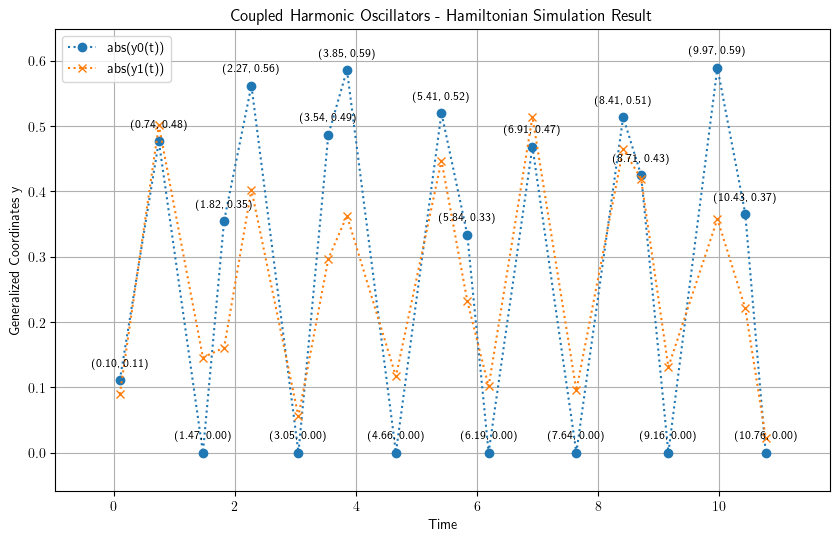

In [10]:
# Define time spans and results
states = [results[i][0].value.counts for i in range(len(results))]

# Initialize lists for y and v values
y0, y1, v0, v1 = [], [], [], []

# Process results
E = 1.0
for result in states:
    y, vy = decode_state(result, N, M, K, E)
    y0.append(y[0].subs(values))
    y1.append(y[1].subs(values))
    v0.append(vy[0])
    v1.append(vy[1])
    
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_spans, y0, label='abs(y0(t))', linestyle='dotted', marker='o')
plt.plot(time_spans, y1, label='abs(y1(t))', linestyle='dotted', marker='x')
# Annotate each point with its coordinates
for i in range(len(time_spans)):
    plt.annotate(f'({time_spans[i]:.2f}, {y0[i]:.2f})', 
                 (time_spans[i], y0[i]), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=8)
# Increase axes margin
plt.margins(y=0.1)
plt.margins(x=0.1)
plt.xlabel('Time')
plt.ylabel('Generalized Coordinates y')
plt.legend()
plt.title('Coupled Harmonic Oscillators - Hamiltonian Simulation Result')
plt.grid(True)
plt.show()

### analytical solution  

Following is the general solution for $y_0(t)$ and $y_1(t)$ to compare with the results of Hamiltonian simulation.

<div style="border: 2px solid orange; padding: 10px;">
    
When an initial condition is created for the system, the system is reverted into one specific _normal mode_ at that moment and the resulting motion would be periodic if all ratios $\omega_{\alpha}/\omega_{\beta}$ are rational numbers.

</div>

In [11]:
####################################################
# Functions to prepare analytical solutions
#  - prepare_analytical_solution_symbols(n)
#  - prepare_amps_sys_eq(n, t, omega, AMPS, Y, A)
#  - find_normal_modes(eqns, omega, AMPS, values)
####################################################


# Prepare symbols for analytical solutions for y
def prepare_analytical_solution_symbols(n):
    """Return all symbols required for deriving analytical results."""
    # Define symbols
    t, omega = symbols('t omega', real=True)
    AMPS = symbols(f'A0:{n}', real=True)
    Y = [Function(f'y{i}')(t) for i in range(n)]
    for i, symbol in enumerate(AMPS, start=0):
        exec(f'A{i} = symbol')
    # Amplitude symbols
    phi = [symbols(f'phi{k}', real=True) for k in range(n)]
    delta = [symbols(f'delta{k}', real=True) for k in range(n)]
    # Return symbols
    return t, omega, AMPS, Y, phi, delta


# Prepare system of equations for amplitudes
def prepare_amps_sys_eq(n, t, omega, AMPS, Y, A):
    """Return the full system of equations of motion."""
    # Define the vector y
    y = Matrix(Y)
    # Define differential equations separately
    eqns = []
    for i in range(n):
        eqn = Eq(y[i].diff(t, t)/exp(j * omega * t), (-A * y)[i]/exp(j * omega * t))
        for k in range(n):
            eqn = eqn.subs({y[k].diff(t, t): -omega**2 * y[k]})
            eqn = eqn.subs({y[k]: AMPS[k] * exp(j * omega * t)})
            # Simplify the equations
        eqns.append(simplify(eqn))
    # Return system of equations for y amplitudes
    return eqns


# Find eigenfrequencies and eigenvectors of the Omega matrix
def find_normal_modes(eqns, omega, AMPS, values):
    """Return a dictionary of eigenfrequencies and the corresponding eigenvectors."""
    UPSILON = Matrix([
        [(eq.lhs - eq.rhs).coeff(AMPS[j]) for j in range(len(eqns))]
        for eq in eqns
    ]).subs(values)
    normal_modes = {}
    omega2_list = solve(UPSILON.det(), omega**2)
    for omega2 in omega2_list:
        OMEGA = (UPSILON + (omega**2) * eye(UPSILON.shape[0])).subs({omega**2: omega2})
        for eigenvalue, multiplicity, eigenvector in OMEGA.eigenvects():
            if math.isclose(eigenvalue, omega2, rel_tol=1e-9):
                normal_modes[eigenvalue] = eigenvector
    return normal_modes


# Find amplitudes on the basis of initial conditions
def find_c_alphas(normal_modes, phi, delta, initial_condition):
    """Return the full amplitudes."""
    omega2s = list(normal_modes.keys())
    n = len(omega2s)
    # 
    A_vec = {i: [normal_modes[omega2s[alpha]][0][i] * delta[alpha] * exp(j * phi[alpha]) for alpha in range(n)] for i in range(n)}
    V_vec = {i: [normal_modes[omega2s[alpha]][0][i] * j * sqrt(omega2s[alpha]) * delta[alpha] * exp(j * phi[alpha]) for alpha in range(n)] for i in range(n)}
    A0 = [sum(A_vec[i]) for i in range(n)]
    V0 = [sum(V_vec[i]) for i in range(n)]
    # 
    eqns = [Eq(initial_condition[i][l], A0[i] if l == 0 else V0[i]) for i in range(n) for l in range(2)]
    variables = [var for i in range(n) for var in (delta[i], phi[i])]
    #
    numerical_equations = [lambdify(variables, eq.lhs - eq.rhs, 'numpy') for eq in eqns]
    initial_guess = [1, np.pi / 2] * n
    #
    solution = fsolve(lambda vars: [f(*vars).real for f in numerical_equations], initial_guess)
    return {variables[i]: solution[i] for i in range(len(solution))}


# Define a function to find roots in a given interval
def find_roots_in_interval(f, interval, num_points=100):
    x_vals = np.linspace(interval[0], interval[1], num_points)
    roots = []
    for x0 in x_vals:
        root = fsolve(f, x0)
        if interval[0] <= root <= interval[1]:
            roots.append(root[0])
    # Remove duplicates and sort
    roots = np.unique(np.round(roots, decimals=6))
    return roots

Find the characteristic frequencies $\omega_1$ and $\omega_2$ and the corresponding eigenvectors :

In [12]:
# Define the number of superposition terms
n = 2 

# Define matrices B and A
B = Matrix(B)
A = B * B.H

# Find characteristic frequencies
t, omega, AMPS, Y, phi, delta = prepare_analytical_solution_symbols(n)
eqns = prepare_amps_sys_eq(n, t, omega, AMPS, Y, A)
normal_modes = find_normal_modes(eqns, omega, AMPS, values)
for i in range(n): 
    display(Markdown(f"**Normal Mode {i+1} :**"))
    display(Markdown(f"$\omega^2_{i}$ = {list(normal_modes.keys())[i]}"))
    display(list(normal_modes.values())[i][0])

**Normal Mode 1 :**

$\omega^2_0$ = 1.31385933836549

Matrix([
[ 0.64262055057565],
[0.766184591321079]])

**Normal Mode 2 :**

$\omega^2_1$ = 4.18614066163451

Matrix([
[0.766184591321079],
[-0.64262055057565]])

Obtain $r_{\alpha}\exp(i\phi_{\alpha})$'s for the initial condition $y_0(0) = y_1(0) = 0$, $\dot{y}_0(0) = 1$, and $\dot{y}_1(0) = -1$ :

In [13]:
initial_condition = [
    [0.0, 1.0],
    [0.0, -1.0]
]
sol = find_c_alphas(normal_modes, phi, delta, initial_condition)

/tmp/ipykernel_126113/3685789145.py:86: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(f, x0)


Roots in the interval (0, 11): 
# root1 : 1.471546
# root2 : 3.048756
# root3 : 4.658484
# root4 : 6.188469
# root5 : 7.637458
# root6 : 9.156412
# root7 : 10.762932
Critical points in the interval (0, 11): 
# critical point1 : (0.744077, 0.47477241025113104)
# critical point2 : (2.272299, -0.5619497627546465)
# critical point3 : (3.849321, 0.5936190812451946)
# critical point4 : (5.410031, -0.5204723230705156)
# critical point5 : (6.912118, 0.4584502489725713)
# critical point6 : (8.40996, -0.5114210303285416)
# critical point7 : (9.965685, 0.5903624428416214)


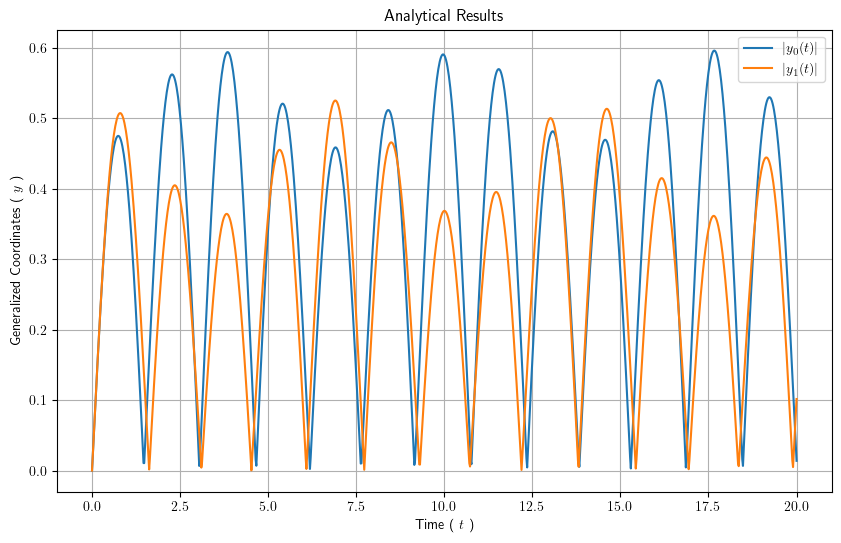

In [14]:
# Time array
t = np.linspace(0, 20, 1000)
# Define the symbolic variable
ts = symbols('t')

yc, yc_np, vc, vc_np = [], [], [], []
for i in range(n):
    y_sym = sum(list(normal_modes.values())[k][0][i] * delta[k] * cos(sqrt(list(normal_modes.keys())[k]) * ts + phi[k]) for k in range(n)).subs(sol)
    dy_dt = diff(y_sym, ts)
    # Convert the symbolic expression to a numerical function
    y_func = lambdify(ts, y_sym, 'numpy')
    v_func = lambdify(ts, dy_dt, 'numpy')
    yc_np.append(y_func)
    vc_np.append(v_func)
    yc.append(abs(y_func(t)))
    vc.append(abs(v_func(t)))

# Find the roots in the interval [0, 20]
interval = (0, 11)
roots = find_roots_in_interval(yc_np[0], interval)
criticalpoints = find_roots_in_interval(vc_np[0], interval)
print(f"Roots in the interval {interval}: ")
for i in range(len(roots)):
    print(f'# root{i+1} : {roots[i]}')
print(f"Critical points in the interval {interval}: ")
en = 0
for c in criticalpoints:
    en += 1
    print(f"# critical point{en} : ({c}, {yc_np[0](c)})")

# Plot the function
plt.figure(figsize=(10, 6))
for i in range(len(yc)):
    plt.plot(t, yc[i], label=fr'$\left| y_{i}(t) \right|$')
plt.xlabel(r'Time ( $t$ )')
plt.ylabel(r'Generalized Coordinates ( $y$ )')
plt.title('Analytical Results')
plt.legend()
plt.grid(True)
plt.show()